Using device: cuda


c:\Users\ipits\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0 | LR: 1.0e-05 | Total: 6.00e+00 | Grad: 1.13e+00 | Pot: 4.88e+00 | BC: 9.23e-07
Epoch 1000 | LR: 1.0e-05 | Total: 1.41e+00 | Grad: 4.07e-01 | Pot: 1.00e+00 | BC: 2.88e-06
Epoch 2000 | LR: 1.0e-05 | Total: 1.15e+00 | Grad: 4.03e-01 | Pot: 7.44e-01 | BC: 2.73e-06
Epoch 3000 | LR: 1.0e-05 | Total: 1.07e+00 | Grad: 4.20e-01 | Pot: 6.49e-01 | BC: 6.21e-06
Epoch 4000 | LR: 1.0e-05 | Total: 1.03e+00 | Grad: 4.30e-01 | Pot: 6.02e-01 | BC: 1.64e-06
Epoch 5000 | LR: 1.0e-05 | Total: 1.02e+00 | Grad: 4.38e-01 | Pot: 5.82e-01 | BC: 2.72e-06
Epoch 6000 | LR: 1.0e-05 | Total: 1.02e+00 | Grad: 4.42e-01 | Pot: 5.72e-01 | BC: 2.74e-06
Epoch 7000 | LR: 1.0e-05 | Total: 1.01e+00 | Grad: 4.45e-01 | Pot: 5.67e-01 | BC: 2.73e-06
Epoch 8000 | LR: 1.0e-05 | Total: 1.02e+00 | Grad: 4.44e-01 | Pot: 5.63e-01 | BC: 1.61e-05
Epoch 9000 | LR: 1.0e-05 | Total: 1.01e+00 | Grad: 4.47e-01 | Pot: 5.64e-01 | BC: 2.73e-06
Epoch 10000 | LR: 1.0e-05 | Total: 1.01e+00 | Grad: 4.48e-01 | Pot: 5.64e-01 | BC: 2.73e-06
E

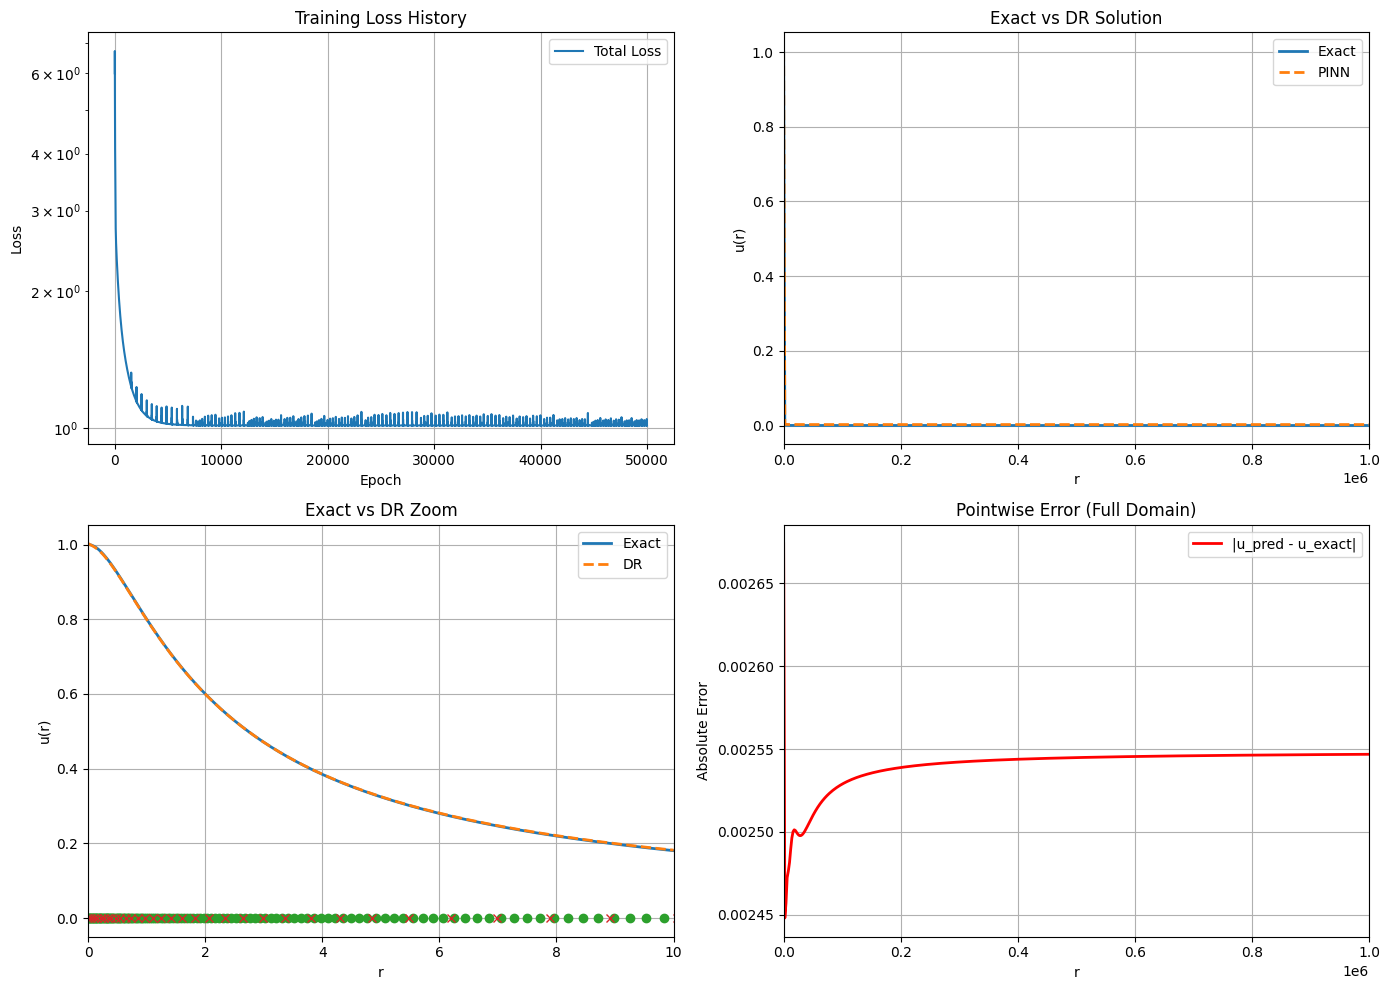

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.manual_seed(123)

# Parameters
epsilon = 1e-4
r_max = 1000000.0
m = 1.0
sigma = 0.065
epochs = 50000
N_grad = 512  # More samples for gradient term
N_pot = 128   # Fewer samples for potential term
LR = 1e-5
GAMMA = 1.0
bc_weight = 600

# Model definition
class FCNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 256), nn.Tanh(),
            nn.Linear(256, 256), nn.Tanh(),
            nn.Linear(256, 256), nn.Tanh(),
            nn.Linear(256, 1)
        )
        self.net.apply(self._init_weights)

    def _init_weights(self, layer):
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)

    def forward(self, r):
        return self.net(r)

# A(r) function
def A(r, m):
    r = r.to(dtype=torch.float64)
    A_val = m * (6 + 6 * r + r ** 2) * (2 * r * (2 + 2 * r + r ** 2) + m * (2 + 6 * r + 5 * r ** 2)) ** 7 \
            / (32 * (r ** 7) * (2 + 2 * r + r ** 2) ** 10)
    return A_val

# Deep Ritz loss with split integration
def deep_ritz_loss_split(model, r_grad, r_pot, r_boundary, m):
    sinh_1_over_sigma = torch.sinh(torch.tensor(1.0 / sigma, dtype=torch.float64, device=device))
    numerator = sigma * sinh_1_over_sigma

    # Gradient term
    r_grad = r_grad.requires_grad_(True)


    u_grad = model(r_grad)
    u_r = torch.autograd.grad(u_grad, r_grad, torch.ones_like(u_grad), create_graph=True)[0]
    grad_term = 0.5 * u_r.pow(2) * r_grad.pow(2)
    denominator_grad = r_max * torch.sqrt(1 + ((r_grad / r_max) * sinh_1_over_sigma).pow(2))
    p_grad = numerator / denominator_grad
    grad_loss = (grad_term / p_grad).mean()

    # Potential term
    # r_pot=r_pot.requires_grad_(True)

    u_pot = model(r_pot)
    A_val = A(r_pot, m)
    base = 1 + m / (2 * r_pot) + u_pot
    pot_term = (1.0 / 6.0) * A_val * base.pow(-6) * r_pot.pow(2)
    denominator_pot = r_max * torch.sqrt(1 + ((r_pot / r_max) * sinh_1_over_sigma).pow(2))
    p_pot = numerator / denominator_pot
    pot_loss = (pot_term / p_pot).mean()

    # Boundary condition
    bc_loss = model(r_boundary).pow(2).mean()

    total_loss = grad_loss + pot_loss + bc_weight * bc_loss
    return total_loss, grad_loss, pot_loss, bc_loss

# Exact solution
def u_exact(r, m):
    return 2 * m * (1 + r) / (1 + (1 + r) ** 2)

# Sinh sampling function
def sinh_sample(N):
    # x = torch.rand(N, 1, dtype=torch.float64, device=device) * (1.0 - epsilon) + epsilon
    x = torch.linspace(epsilon, 1.0, N, dtype=torch.float64, device=device).unsqueeze(1)
    return r_max * torch.sinh(x / sigma) / torch.sinh(torch.tensor(1.0 / sigma, dtype=torch.float64, device=device))

# Model, optimizer, scheduler
model = FCNet().double().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

r_boundary = torch.tensor([[r_max]], dtype=torch.float64, device=device)

# Logging
loss_history = []
energy_loss_history = []
bc_loss_history = []



for epoch in range(epochs):
    model.train()
    r_grad = sinh_sample(N_grad)
    r_pot = sinh_sample(N_pot)

    # # Resample every 10 epochs
    # if epoch % 10 == 0:
    #     r_grad = sinh_sample(N_grad)
    #     r_pot = sinh_sample(N_pot)

    optimizer.zero_grad()
    total_loss, grad_loss, pot_loss, bc_loss = deep_ritz_loss_split(model, r_grad, r_pot, r_boundary, m)
    total_loss.backward()
    optimizer.step()
    scheduler.step()

    loss_history.append(total_loss.item())
    energy_loss_history.append((grad_loss + pot_loss).item())
    bc_loss_history.append(bc_loss.item())

    if epoch % 1000 == 0:
        lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch} | LR: {lr:.1e} | Total: {total_loss:.2e} | Grad: {grad_loss:.2e} | Pot: {pot_loss:.2e} | BC: {bc_loss:.2e}")
# torch.save(model.state_dict(), 'deepritz_linspace9_weights.pth')
# Evaluation
r_test = torch.linspace(epsilon, r_max, 500, dtype=torch.float64, device=device).unsqueeze(1)
u_exact_vals = u_exact(r_test.cpu().numpy(), m)

model.eval()
with torch.no_grad():
    u_pred = model(r_test).cpu().numpy()

avg_pointwise_error = np.mean(np.abs(u_pred - u_exact_vals))
print(f"\nAverage point-wise error: {avg_pointwise_error:.6e}")

# Plotting
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.semilogy(loss_history, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(r_test.cpu(), u_exact_vals, label='Exact', linewidth=2)
plt.plot(r_test.cpu(), u_pred, '--', label='PINN', linewidth=2)
# plt.plot(r_grad.cpu().detach(),0*r_grad.cpu().detach(),'o')
# plt.plot(r_pot.cpu().detach(),0*r_pot.cpu().detach(),'x')
plt.xlabel('r')
plt.ylabel('u(r)')
plt.title('Exact vs DR Solution')
plt.legend()
plt.grid()
plt.xlim(0, r_max)

r_test2 = torch.linspace(epsilon, 10, 500, dtype=torch.float64, device=device).unsqueeze(1)
u_exact_vals2 = u_exact(r_test2.cpu().numpy(), m)
with torch.no_grad():
    u_pred2 = model(r_test2).cpu().numpy()

plt.subplot(2, 2, 3)
plt.plot(r_test2.cpu(), u_exact_vals2, label='Exact', linewidth=2)
plt.plot(r_test2.cpu(), u_pred2, '--', label='DR', linewidth=2)
plt.plot(r_grad.cpu().detach(),0*r_grad.cpu().detach(),'o')
plt.plot(r_pot.cpu().detach(),0*r_pot.cpu().detach(),'x')
plt.xlabel('r')
plt.ylabel('u(r)')
plt.title('Exact vs DR Zoom')
plt.legend()
plt.grid()
plt.xlim(0, 10)

plt.subplot(2, 2, 4)
pointwise_error = np.abs(u_pred - u_exact_vals)
plt.plot(r_test.cpu(), pointwise_error, color='red', label='|u_pred - u_exact|', linewidth=2)
plt.xlabel('r')
plt.ylabel('Absolute Error')
plt.title('Pointwise Error (Full Domain)')
plt.legend()
plt.grid()
plt.xlim(0, r_max)

plt.tight_layout()
plt.savefig("deepritz_toy1D.pdf")
plt.show()
